# Introduction
* In this notebook, I will explor PyStan package.
* [Reference](https://pystan.readthedocs.io/en/latest/getting_started.html)

In [1]:
import pystan
import scipy
import arviz
import plotly.express as px
import plotly.graph_objs as go
import psutil

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Example: eight schools

In [ ]:
data {
int<lower=0> J; // # schools
real y[J]; // estimated treatment
real<lower=0> sigma[J]; // std err of effect
}
parameters {
real theta[J]; // school effect
real mu; // mean for schools
real<lower=0> tau; // variance between schools
}
model {
theta ~ normal(mu, tau);
y ~ normal(theta, sigma);
}

In [2]:
# ref: https://pystan.readthedocs.io/en/latest/getting_started.html
# https://astrostatistics.psu.edu/su14/lectures/Daniel-Lee-Stan-2.pdf

schools_code = """
data {
    int<lower=0> J; // # schools
    real y[J]; // estimated treatment
    real<lower=0> sigma[J]; // std err of effect
}
parameters {
    real theta[J]; // school effect
    real mu; // mean for schools
    real<lower=0> tau; // variance between schools
}
model {
    theta ~ normal(mu, tau);
    y ~ normal(theta, sigma);
}
"""

schools_dat = {'J': 8,
               'y': [28,  8, -3,  7, -1,  1, 18, 12],
               'sigma': [15, 10, 16, 11,  9, 11, 10, 18]}

sm = pystan.StanModel(model_code=schools_code)
fit = sm.sampling(data=schools_dat, iter=3000, warmup=300, chains=3, 
                  thin=1) # control={'adapt_delta': 0.9, 'max_treedepth': 30}

#fit = sm.sampling(data=schools_dat, iter=1000, warmup=300, chains=4, thin=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb61d0eae3d6ef378c04e5c9a4c3d37a NOW.


In [3]:
# Extract samples
la = fit.extract(permuted=True)  # return a dictionary of arrays

## return an array of three dimensions: iterations, chains, parameters
a = fit.extract(permuted=False)

In [4]:
print(fit)

Inference for Stan model: anon_model_bb61d0eae3d6ef378c04e5c9a4c3d37a.
3 chains, each with iter=3000; warmup=300; thin=1; 
post-warmup draws per chain=2700, total post-warmup draws=8100.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1]  11.54     0.2   8.45  -2.49   5.74  10.51  15.99  31.66   1763    1.0
theta[2]    7.7    0.12   6.49  -5.24   3.54   7.65  11.86  20.54   3147    1.0
theta[3]   5.75    0.14   7.88  -11.6    1.4   6.09  10.67  20.63   3353    1.0
theta[4]   7.48    0.11   6.82  -6.46   3.29   7.44  11.62  21.08   3744    1.0
theta[5]   4.56    0.12   6.51  -9.37   0.68   4.89   8.96  16.52   3099    1.0
theta[6]    5.6    0.12   6.94  -9.35   1.49   5.82  10.12  18.52   3082    1.0
theta[7]  10.77    0.17   6.94  -1.51   5.91   10.3  14.95   26.2   1654    1.0
theta[8]   8.29    0.14   8.33  -8.35   3.48   8.09  12.99  25.49   3729    1.0
mu         7.59    0.12    5.2  -2.34   4.28   7.55  10.87  17.74   1981    1.0
tau        7

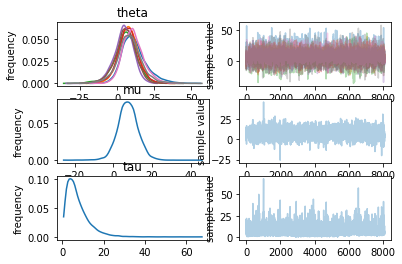

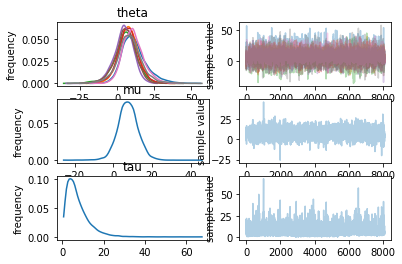

In [5]:
fit.plot()

# Create two samples and use PyStan to see fitting results

In [2]:
size = 10000
shape_list = [0.8, 1]  # k  (alpha)
scale_general = 10  # theta   (beta = 1 / theta)


x1 = np.random.gamma(shape=shape_list[0], scale=scale_general, size=size)
x2 = np.random.gamma(shape=shape_list[1], scale=scale_general, size=size)

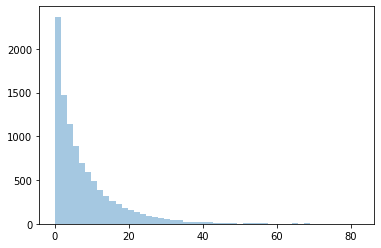

In [3]:
sns.distplot(x1, kde=False)

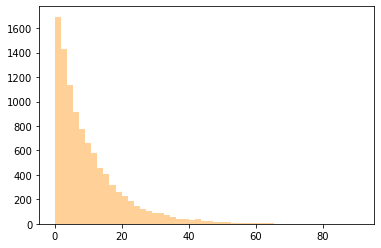

In [4]:
sns.distplot(x2, kde=False, color='darkorange')

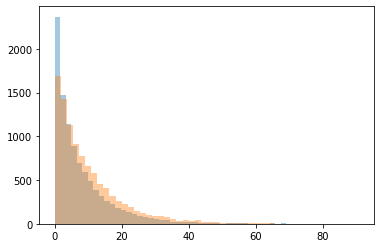

In [5]:
sns.distplot(x1, kde=False)
sns.distplot(x2, kde=False)

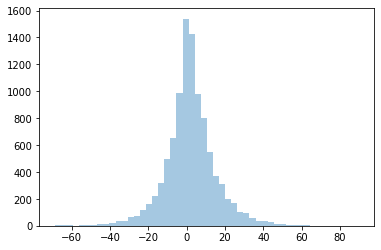

In [6]:
sns.distplot(x2 - x1, kde=False)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_04cbf2f663896ca538174a7c8d43834b NOW.


Inference for Stan model: anon_model_04cbf2f663896ca538174a7c8d43834b.
3 chains, each with iter=3000; warmup=300; thin=1; 
post-warmup draws per chain=2700, total post-warmup draws=8100.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
shape1    0.8  1.3e-4 8.4e-3   0.78   0.79    0.8    0.8   0.81   3989    1.0
shape2   0.99  1.7e-4   0.01   0.97   0.98   0.99    1.0   1.01   3649    1.0
scale     0.1  2.0e-5 1.1e-3    0.1    0.1    0.1    0.1    0.1   3271    1.0
d        0.19  1.4e-4   0.01   0.17   0.18   0.19    0.2   0.21   5590    1.0
lp__   -6.4e4    0.02   1.28 -6.4e4 -6.4e4 -6.4e4 -6.4e4 -6.4e4   2958    1.0

Samples were drawn using NUTS at Wed Mar  4 15:35:01 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


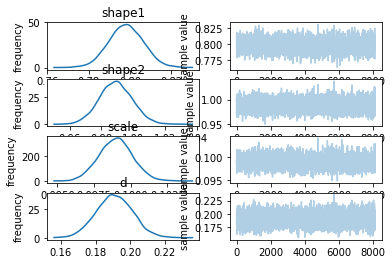

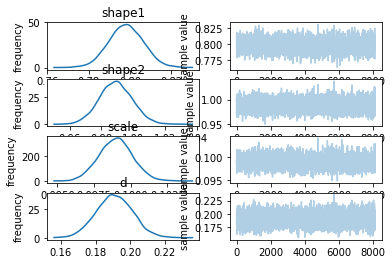

In [7]:
before_after_code = """
data {
    int<lower=0> J; // length of data
    vector[J] x1; // before
    vector[J] x2; // after
}
parameters {
    real<lower=0> shape1;
    real<lower=0> shape2;
    real<lower=0> scale;
}
model {
    x1 ~ gamma(shape1, scale);
    x2 ~ gamma(shape2, scale);
}

generated quantities {
    real d;
    
    d = shape2 - shape1;
}
"""

before_after_data = {'J': size,
               'x1': x1,
               'x2': x2}

sm = pystan.StanModel(model_code=before_after_code)
fit = sm.sampling(data=before_after_data, iter=3000, warmup=300, chains=3)

print(fit)
fit.plot()

In [8]:
a = fit.extract(permuted=True)

In [9]:
a

OrderedDict([('shape1',
              array([0.79546818, 0.79502047, 0.7861454 , ..., 0.80573359, 0.79257089,
                     0.79206966])),
             ('shape2',
              array([0.9869567 , 0.99645867, 0.98790048, ..., 0.99317194, 0.96443416,
                     0.98044603])),
             ('scale',
              array([0.09847067, 0.09919196, 0.09904972, ..., 0.09844316, 0.09797041,
                     0.09740325])),
             ('d',
              array([0.19148851, 0.2014382 , 0.20175508, ..., 0.18743835, 0.17186328,
                     0.18837638])),
             ('lp__',
              array([-63710.14312095, -63710.52569937, -63711.7676777 , ...,
                     -63711.76811709, -63713.38038988, -63711.0336571 ]))])

In [10]:
len(a['shape1'])

8100

In [12]:
fit.summary()

OrderedDict([('summary',
              array([[ 7.98097258e-01,  1.32340217e-04,  8.35891148e-03,
                       7.81824211e-01,  7.92494004e-01,  7.98070378e-01,
                       8.03763172e-01,  8.14491724e-01,  3.98947516e+03,
                       1.00125199e+00],
                     [ 9.89054889e-01,  1.70238588e-04,  1.02839133e-02,
                       9.69088351e-01,  9.82101157e-01,  9.88949319e-01,
                       9.95928361e-01,  1.00958229e+00,  3.64922628e+03,
                       9.99819060e-01],
                     [ 9.89851961e-02,  2.00907989e-05,  1.14900906e-03,
                       9.67657234e-02,  9.82094272e-02,  9.89846559e-02,
                       9.97440705e-02,  1.01249361e-01,  3.27078874e+03,
                       1.00032194e+00],
                     [ 1.90957632e-01,  1.39355289e-04,  1.04187274e-02,
                       1.70767893e-01,  1.83868482e-01,  1.90814746e-01,
                       1.98035470e-01,  2.11623803e-

In [13]:
shape1 = fit['shape1']
shape2 = fit['shape2']
scale = fit['scale']
d = fit['d']
lp = fit['lp__']

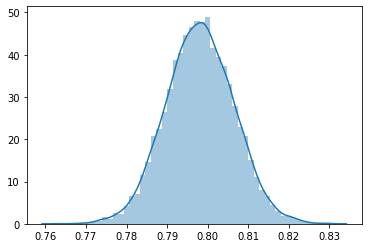

In [14]:
sns.distplot(shape1)

In [15]:
fig = px.histogram(x=shape1, labels={"x":"alpha1"})
fig.show("png")

ValueError: 
The orca executable is required to export figures as static images,
but it could not be found on the system path.

Searched for executable 'orca' on the following path:
    /Users/yao/miniconda3/bin
    /opt/miniconda3/condabin
    /usr/local/bin
    /usr/bin
    /bin
    /usr/sbin
    /sbin

If you haven't installed orca yet, you can do so using conda as follows:

    $ conda install -c plotly plotly-orca

Alternatively, see other installation methods in the orca project README at
https://github.com/plotly/orca

After installation is complete, no further configuration should be needed.

If you have installed orca, then for some reason plotly.py was unable to
locate it. In this case, set the `plotly.io.orca.config.executable`
property to the full path of your orca executable. For example:

    >>> plotly.io.orca.config.executable = '/path/to/orca'

After updating this executable property, try the export operation again.
If it is successful then you may want to save this configuration so that it
will be applied automatically in future sessions. You can do this as follows:

    >>> plotly.io.orca.config.save()

If you're still having trouble, feel free to ask for help on the forums at
https://community.plot.ly/c/api/python


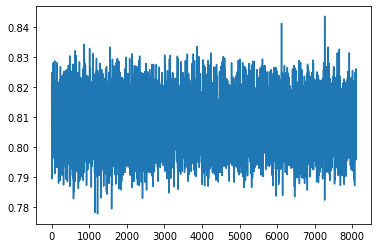

In [76]:
plt.plot(a['shape1'])

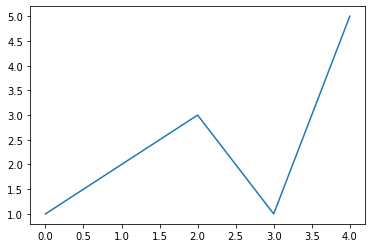

In [81]:
plt.plot([1,2,3,1,5])

In [137]:
before_after_code = """
data {
    int<lower=0> J; // length of data
    vector[J] x1; // before
    vector[J] x2; // after
}
parameters {
    real<lower=0> shape1;
    real<lower=0> shape2;
    real<lower=0> scale;
}
model {
    x1 ~ uniform(shape1 - 1, shape1 + 1);
    x2 ~ uniform(shape2 - 1, shape2 + 1);
}

generated quantities {
    real d;
    
    d = shape2 - shape1;
}
"""

before_after_dat = {'J': size,
               'x1': x1,
               'x2': x2}

sm = pystan.StanModel(model_code=before_after_code)
fit = sm.sampling(data=before_after_dat, iter=3000, warmup=300, chains=3)
                  # thin=1) # control={'adapt_delta': 0.9, 'max_treedepth': 30}

print(fit)
fit.plot()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3a0a6957952c8151fd5eef84d8c8b5c6 NOW.


RuntimeError: Initialization failed.